Now we move on to the first nonlinear PDE, which we solve both eliminating variables and relaxing equality constraints, and then applying the Levenberg-Marquardt algorithm. First need to construct differential operators, etc. etc. 

In [1]:
import jax
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as random
from jax import vmap, grad, jacobian

jax.config.update("jax_enable_x64",True)

key = random.key(619420)
key1, key2 = random.split(key)

Burgers' equation is given by $$ \partial_t u  + u \partial_s u  - \nu \partial_s^2 u = 0, \quad (s, t) \in (-1, 1) \times (0, 1]$$ with $$u(s, 0) = \sin(\pi s), \quad u(-1, t) = u(1, t) =0 $$ and take $\nu = 0.002$. 

First define the anisotropic kernel we will be using, to account for different scales of time $t$ and space $s$:

In [2]:
nu = 0.02
SIGMA = jnp.array([1/20, 1/3])

def get_k(sigma):
    def k(x1, x2):
        return jnp.exp(-(1/sigma[0]**2) * (x1[0] - x2[0])**2 - (1/sigma[1]**2) * (x1[1] - x2[1])**2)
    return k

For the following, we assume $x = (s, t) \in \R^2$, and for JAX we define the argument to the differential operators as depending only on $x$, hence to differentiate kernel functions we need a wrapper that isolates either $x$ or $y$ 

In [ ]:
# L represent the functionals, missing composition with evaluation functionals. 
# function with respect to t
def L1(fun, argnums):
    def function(x, y):
        return grad(fun, argnums)(x, y)[1]
    return function

# function with respect to s
def L2(fun, argnums):
    def function(x, y):
        return grad(fun, argnums)(x, y)[0]
    return function

# partial_s^2 fun
def L3(fun, argnums):
    def function(x, y):
        return L2(L2(fun, argnums), argnums)(x, y)
    return function

def L4(fun, argnums):
    return fun

# Interior operator
def P(v1, v2, v3, v4):
    return v1 + v4*v2 - nu*v3

# Boundary operator
def B(u1, argnums = None):
    return u1

operators = {"L1": L1, "L2":L2, "L3":L3, "L4": L4, "L5": B }

def get_P_ker(kernel, argnums):
    def curlyP(x1, x2):
        return P(L1(kernel, argnums)(x1, x2), L2(kernel, argnums)(x1, x2), L3(kernel, argnums)(x1, x2), L4(kernel, argnums)(x1, x2))
    return curlyP
    

# For a univariate function $u(x)$, we may simply kernelize $u$ by considering $k(x, y) = u(x)$.
# Can be done with lambda functions, such that this is solved with one line of code. 
# argnums = 0 because 1 would be wrt y, but y is not used. SANITY CHECK: argnums=1 should always return 0.0. 
def get_P_fun(fun):
    return lambda x: get_P_ker(lambda x, y: fun(x), argnums=0)(x, x)

The function vec_diff_combo vectorizes two functionals as a combination. It is supposed to represent $$\mathcal{K}(\mathbf{\phi}, \mathbf{\psi})$$

Example: If we now say first(X_I, X_I), where first= kernelized_derivatives_combinations[(1, 2
)] it should return a $|X_I| \times |X_I|$ matrix $\Theta$ where $$ \Theta_{i, j} = L_1^{\mathbf{x}}L_2^{\mathbf{x}'} K(x, x') |_{(x, x') = (x_i, x_j)}$$ where $x_i$ is the $i$ th row of $X_I$ and $x_j$ is the $j$ th row of $X_I$. Note that if we called the operators $L_1$ and $L_5$ instead we should pass $X_I$ and $X_B$, since the $L_5$ operator is a boundary one, resulting in a $(n_I, n_B)$ sized matrix.  

We will need a small sanity check with $L_5, L_5$ which should just evaluate the kernel, and $L_1, L_5$ which is more intricate. Should also try an asymmetric method not involving derivatives of the kernel.  

The domain is $\Omega = [-1, 1] \times (0, 1]$

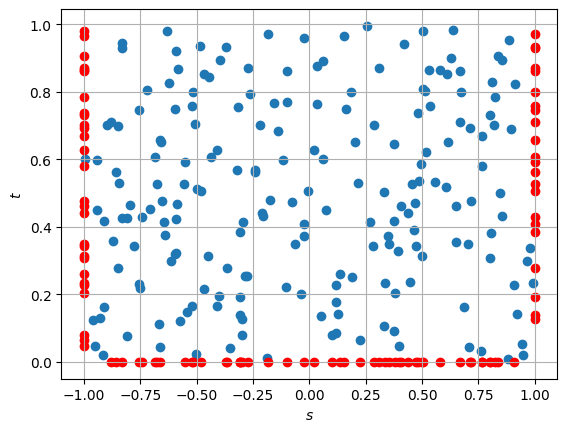

In [4]:
n_I = 200
n_B = 100
p = 1/2

X_I = jnp.concatenate((2*random.uniform(key1, shape=(n_I, 1)) - 1, random.uniform(key2, shape=(n_I, 1))), axis=1)
bd1 = jnp.concatenate((2*random.bernoulli(key1, p=p, shape=(n_B//2, 1))-1, random.uniform(key2, shape=(n_B//2, 1))), axis=1)
bd2 = jnp.concatenate((2*random.uniform(key1, shape=(n_B//2, 1)) - 1, jnp.zeros(shape=(n_B//2, 1))), axis=1)
X_B = jnp.concatenate((bd1, bd2), axis=0)

plt.scatter(X_I[:, 0], X_I[:, 1])
plt.scatter(X_B[:, 0], X_B[:, 1], color='r')
plt.ylabel('$t$')
plt.xlabel("$s$")
plt.grid()

In [42]:
y_I = jnp.zeros(X_I.shape[0])
y_B = jnp.concatenate((jnp.zeros(shape=(n_B//2)), jnp.sin(jnp.pi*X_B[:n_B//2, 0])), axis=0)
y = jnp.concatenate((y_I, y_B))


# 4 differential operators, 1 boundary operator
Q   = 5 
Q_I = 4

N = n_I*Q_I + n_B*(Q - Q_I) # total number of functionals and point evaluations

def F(z):

    # z  dim N
    z_B = z[:n_B]
    z_I = z[n_B:].reshape((n_I, Q_I))
    
    # Create vectorized F function, which we then use for F(z) = y, where z are the point values of functionals applied to u. 
    F_vec = jnp.concatenate((P(*jnp.hsplit(z_I, Q_I)).flatten(), B(*jnp.split(z_B, Q-Q_I)).flatten()))

    return F_vec

z = jnp.ones((N, ))

print(F(z).shape)

(300,)


Creating $K$, create helper function that returns pair (X1, X2) where X1, X2 are X_I, X_B depending on tuple argument

In [43]:
def data_tuple(i, j):
    return (X_I if i != 5 else X_B, X_I if j != 5 else X_B)

In [7]:
kernel = get_k(SIGMA)
curlyP = get_P_ker(kernel, argnums=0)
bicurlyP = get_P_ker(curlyP, argnums=1)

L1_K = L1(kernel, argnums=0)
L2_K = L2(kernel, argnums=0)
L3_K = L3(kernel, argnums=0)
L4_K = L4(kernel, argnums=0)

def vec_diff_combo(L_x, L_y, function, argnums = (0, 1)):
    return vmap(vmap(L_y(L_x(function, argnums = argnums[0]), argnums = argnums[1]), in_axes = (None,0)), in_axes= (0, None)) 


vec_k = vmap(vmap(kernel, in_axes = (None,0)), in_axes=(0, None))
vec_curlyP = vmap(vmap(curlyP, in_axes = (None,0)), in_axes=(0, None))
vec_bicurlyP = vmap(vmap(bicurlyP, in_axes = (None,0)), in_axes=(0, None))

first = vec_diff_combo(L1, L2, kernel)

# Just like first, we build all possible pair combinations
kernelized_derivatives_combinations = {(i,j): vec_diff_combo(operators[f"L{i}"], operators[f"L{j}"], kernel) for i in range(1, 6) for j in range(1, 6)}

In [59]:
small_K_matrices = [[kernelized_derivatives_combinations[(i,j)](*data_tuple(i,j)) for i in range(1, Q+1)] for j in range(1, Q+1)]

In [ ]:

row_blocks = [np.concatenate(small_K_matrices[i]) for i in range(5)]
full_K = jnp.concatenate(row_blocks, axis=1)

regularized_full_K = full_K + 1e-8*jnp.eye(full_K.shape[0])

print(jnp.linalg.cond(regularized_full_K))
print(jnp.linalg.cond(full_K))

1195090616504695.8
2.0780068719377892e+24


Now gotta set up the minimization problem:

$$ \mathrm{minimize}_{z} \hspace{5pt} z^\top K_{\phi, \phi}^{-1} z \quad s.t. \quad F(z) = y$$ 

which we relax to  
$$ \mathrm{minimize}_{z} \hspace{5pt} z^\top K_{\phi, \phi}^{-1} z + \frac{1}{\beta^2} \|F(z) - y\|^2$$ 

and use the LM algorithm. 

In [66]:
def relaxed_LM(K, F ,y, beta, max_iters, x0, tol = 1e-12, reg = 1e-10, verbose = False):
    errs = []
    x = x0
    obj_val = jnp.linalg.norm(F(x) - y)

    errs.append(obj_val)
    for iter in range(max_iters):
        
        Jac = jacobian(F)(x)

        # print("J", Jac.shape)

        C = Jac.T @ Jac/beta**2+ reg*jnp.eye(len(x))

        x = 1/beta**2 * K @ (Jac.T @ (y - F(x)) - jnp.linalg.solve(jnp.eye(len(x)) + C @ K, K @ Jac.T @ (y - F(x))))

        obj_val = jnp.linalg.norm(F(x) - y)
        errs.append(obj_val)
        if verbose: print(iter, obj_val)
        if obj_val < tol:
            return x, errs

    return x, errs

In [ ]:
x, errs = relaxed_LM(K=regularized_full_K, F = F, y = y, x0 = jnp.zeros_like(z), beta = 0.01, max_iters = 1000, verbose=True) 

0 7.10165331556573e-06
1 1.0369745553723576e+20
2 1.90175323907267e+88
3 inf
4 nan
5 nan
6 nan
7 nan


KeyboardInterrupt: 

In [41]:
print(F(x) - y)

[ 1.25721302e-11  4.17656731e-12  2.82427499e-11 -2.19258856e-11
  2.36671929e-11  4.33071459e-11  2.11226565e-12  1.17134554e-11
  3.14131190e-12 -6.61152753e-11  7.13718842e-12 -9.86040095e-12
  7.20959466e-11 -8.89754970e-12  2.00759660e-12  4.02835348e-11
  1.51537773e-12 -1.36612625e-11 -5.25726367e-13  7.39141702e-12
 -1.26870964e-10 -7.73323193e-11 -2.58723266e-11  1.76139116e-11
  1.48759756e-11 -6.54935856e-12 -1.78981578e-11  4.95752698e-12
  2.38923057e-12  1.85467748e-11 -3.76684095e-12  5.78368664e-11
  4.48343754e-11 -1.36736116e-11 -5.03143499e-13 -3.07049570e-12
  7.56195874e-12 -1.49683147e-12  6.00186822e-12  8.95831146e-12
  5.68806236e-11 -5.05675136e-12  3.20929087e-11 -8.24864390e-12
  4.75900809e-12  8.33975779e-12  9.84839804e-12 -1.89275309e-12
 -5.66845802e-12 -1.42327435e-11 -3.79904644e-12 -4.18776379e-12
 -1.06971220e-10  4.83672927e-12 -8.35330082e-13  2.05422860e-12
 -5.14355056e-12 -2.42669023e-11  1.29441933e-12  8.63428028e-12
 -2.81902581e-13 -1.57703